# Parallel simulations

[![Download JupyterNotebook](https://img.shields.io/badge/Download-Notebook-orange?style=for-the-badge&logo=Jupyter)](https://raw.githubusercontent.com/ANNarchy/ANNarchy.github.io/master/notebooks/MultipleNetworks.ipynb){target="_blank"} [![Download JupyterNotebook](https://img.shields.io/badge/Open_in-Colab-blue?style=for-the-badge&logo=Jupyter)](https://colab.research.google.com/github/ANNarchy/ANNarchy.github.io/master/notebooks/MultipleNetworks.ipynb){target="_blank"}

In [1]:
#!pip install ANNarchy

This example demonstrates the use of `parallel_run()` to simulate the same network multiple times in parallel. 

We start by creating the Izhikevich pulse-coupled network defined in [Izhikevich.ipynb](https://raw.githubusercontent.com/ANNarchy/ANNarchy.github.io/master/notebooks/Izhikevich.ipynb).

In [1]:
import numpy as np
import ANNarchy as ann
ann.clear()

# Create the whole population
P = ann.Population(geometry=1000, neuron=ann.Izhikevich)

# Create the excitatory population
Exc = P[:800]
re = np.random.random(800)
Exc.noise = 5.0
Exc.a = 0.02
Exc.b = 0.2
Exc.c = -65.0 + 15.0 * re**2
Exc.d = 8.0 - 6.0 * re**2
Exc.v = -65.0
Exc.u = Exc.v * Exc.b

# Create the Inh population
Inh = P[800:]
ri = np.random.random(200)
Inh.noise = 2.0
Inh.a = 0.02 + 0.08 * ri
Inh.b = 0.25 - 0.05 * ri
Inh.c = -65.0
Inh.d = 2.0
Inh.v = -65.0
Inh.u = Inh.v * Inh.b

# Create the projections
proj_exc = ann.Projection(Exc, P, 'exc')
proj_inh = ann.Projection(Inh, P, 'inh')

proj_exc.connect_all_to_all(weights=ann.Uniform(0.0, 0.5))
proj_inh.connect_all_to_all(weights=ann.Uniform(0.0, 1.0))

# Create a spike monitor
M = ann.Monitor(P, 'spike')

ann.compile()


ANNarchy 4.8 (4.8.0) on darwin (posix).


We define a simulation method that re-initializes the network, runs a simulation and returns a raster plot. 

The simulation method must take an index as first argument and a ``Network`` instance as second one.

In [2]:
def run_network(idx, net):
    # Retrieve subpopulations
    P_local = net.get(P)
    Exc = P_local[:800]
    Inh = P_local[800:]
    # Randomize initialization
    re = np.random.random(800)
    Exc.c = -65.0 + 15.0 * re**2
    Exc.d = 8.0 - 6.0 * re**2
    ri = np.random.random(200)
    Inh.noise = 2.0
    Inh.a = 0.02 + 0.08 * ri
    Inh.b = 0.25 - 0.05 * ri
    Inh.u = Inh.v * Inh.b
    # Simulate
    net.simulate(1000.)
    # Recordings
    t, n = net.get(M).raster_plot()
    return t, n


``parallel_run()`` uses the ``multiprocessing`` module to start parallel processes. On Linux, it should work directly, but there is an issue on OSX. Since Python 3.8, the 'spawn' method is the default way to start processes, but it does not work on MacOS. The following cell should fix the issue, but it should only be ran once.

In [3]:
import platform
if platform.system() == "Darwin":
    import multiprocessing as mp
    mp.set_start_method('fork')

We can now call ``parallel_run()`` to simulate 8 identical but differently initialized networks. The first call runs the simulations sequentially, while the second is in parallel.

We finally plot the raster plots of the two first simulations.

Running 8 networks sequentially took: 1.3988769054412842 
Running 8 networks in parallel took: 0.3649940490722656 


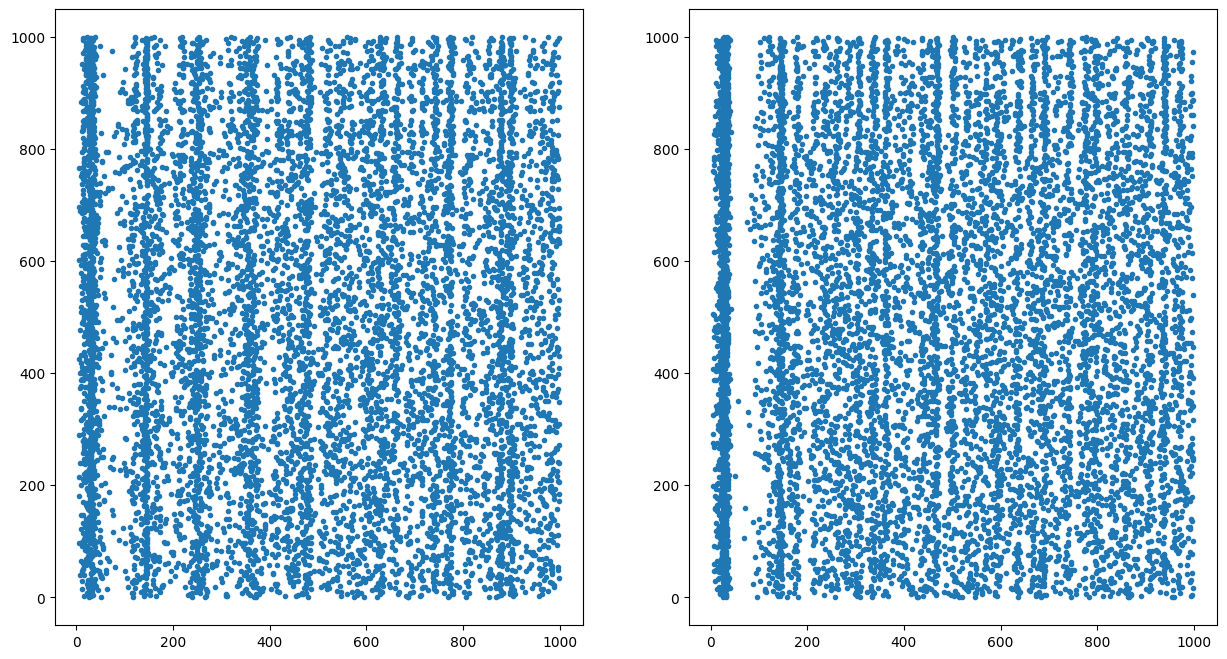

In [4]:
# Run four identical simulations sequentially
vals = ann.parallel_run(method=run_network, number=8, measure_time=True, sequential=True)

# Run four identical simulations in parallel
vals = ann.parallel_run(method=run_network, number=8, measure_time=True)

# Data analysis
t1, n1 = vals[0]
t2, n2 = vals[1]

import matplotlib.pyplot as plt
plt.figure(figsize=(15, 8))
plt.subplot(121)
plt.plot(t1, n1, '.')
plt.subplot(122)
plt.plot(t2, n2, '.')
plt.show()